In [240]:
import numpy as np
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import LogNorm
from matplotlib import gridspec
import aplpy as apl #The Astronomy Plotting Library for python
import astropy
import astropy.units as u
import astropy.constants as C
import astropy.io.fits as fits
import astropy.coordinates as coord
import spectral_cube as SC
from spectral_cube import SpectralCube
from astropy import wcs
from astropy.modeling import models, fitting
import math
from scipy.optimize import curve_fit
from astropy.visualization import ZScaleInterval,LinearStretch,ImageNormalize
from matplotlib.patches import Rectangle
from astropy.stats import sigma_clip
from hoki import load
from hoki.spec import dopcor
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from astropy.convolution import Gaussian1DKernel
from astropy.convolution import convolve
from astropy.io import ascii
from scipy.interpolate import griddata
import os
import heapq
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import extinction as ext

In [241]:
muse = fits.open('/Users/jiangtianxiaoyubei/Desktop/MUSElens/muse_data/extrac_source/CSWA31_autocalib_V2_ZAP.fits')
datacube = SpectralCube.read(muse,hdu=1)
errorcube = SpectralCube.read(muse,hdu=2)

delta_img = round(datacube.header['CDELT2']*3600,2) #0.2 arcsec/pixel
delta_spec = round(datacube.header['CDELT3'],2) #1.25 angstrom/pixel
start_wavelength = muse[1].header['CRVAL3']
unit = datacube.header['BUNIT']
print(unit)

#redshift_given = np.float64(2.7671)
redshift_given = np.float64(2.7673)

10**-20 Angstrom-1 cm-2 erg s-1


In [242]:
def wl2coo(observed_wavelength):
    x = round((observed_wavelength-start_wavelength)/delta_spec)
    return x

def air2vac(lambda_air):
    s = 10**4/lambda_air
    n = 1 + 0.00008336624212083 + 0.02408926869968 / (130.1065924522 - s**2) + 0.0001599740894897 / (38.92568793293 - s**2)
    lambda_vac = lambda_air * n
    return lambda_vac

def vac2air(lambda_vac):
    s = 10*4/lambda_vac
    n = 1 + 0.0000834254 + 0.02406147 / (130 - s**2) + 0.00015998 / (38.9 - s**2)
    lambda_air = lambda_vac/n
    return lambda_air

def cal_z(obs1,obs2,em1,em2):
    return ((obs2 - obs1)/(em2-em1) - 1)

def cal_z2(obs,em):
    return ((obs/em) - 1)

def cal_fwhm(sigma):
    return 2*np.sqrt(2*np.log(2))*sigma

def rs_convert(wl, rs):
    return wl*(1+rs)

def r_rs_convert(wl, rs):
    return wl/(1+rs)

def wl2vel(wl_origin, wl_shifted):
    velocity = ((wl_shifted - wl_origin)/wl_origin) * sp.constants.c * 1e-3 # km/s
    return velocity

In [243]:
wavelength_air = datacube.world[:,0,0][0]
wavelength_air = list(wavelength_air.data)
wavelength_vac = []
wavelength_rest = []

for i in range(len(wavelength_air)):
    wavelength_vac.append(air2vac(wavelength_air[i]))

for i in range(len(wavelength_vac)):
    wavelength_rest.append(wavelength_vac[i]/(1+redshift_given))

S_spec = np.load('/Users/jiangtianxiaoyubei/Desktop/MUSElens/muse_data/extrac_source/S3b_spec.npy').tolist()
S_errspec = np.load('/Users/jiangtianxiaoyubei/Desktop/MUSElens/muse_data/extrac_source/S3b_errspec.npy').tolist()

print('minimum observed wavelength = ' + str(min(wavelength_vac)))
print('maximum observed wavelength = ' + str(max(wavelength_vac)))

print('minimum emitted wavelength = ' + str(min(wavelength_rest)))
print('maximum emitted wavelength = ' + str(max(wavelength_rest)))

minimum observed wavelength = 4751.399318283059
maximum observed wavelength = 9352.636393506004
minimum emitted wavelength = 1261.2213835593286
maximum emitted wavelength = 2482.5833869099893


In [244]:
Rv = 0.31
Av = 0.080
dereddening_chart = pd.DataFrame({'WL':wavelength_vac})

def dereddening_optical(x):
    y = x - 1.82
    a = 1 + 0.17699*y - 0.50447*y**2 - 0.02427*y**3 + 0.72085*y**4 + 0.01979*y**5 - 0.77530*y**6 + 0.32999*y**7
    b = 1.41338*y + 2.28305*y**2 + 1.07233*y**3 - 5.38434*y**4 - 0.62251*y**5 + 5.30260*y**6 - 2.09002*y**7
    A_lambda = (a+b/Rv)*Av
    dereddening_factor = 10**(0.4*A_lambda)
    return dereddening_factor

def dereddening_IR(x):
    a = 0.574*x**1.61
    b = -0.527*x**1.61
    A_lambda = (a+b/Rv)*Av
    dereddening_factor = 10**(0.4*A_lambda)
    return dereddening_factor

dereddening_chart = pd.DataFrame({'WL':wavelength_vac})
dereddening_chart.loc[:,'WL'] = 1/(dereddening_chart.loc[:,'WL']*0.0001)
dereddening_chart.loc[:,'dereddening_factor'] = pd.concat([dereddening_optical(dereddening_chart[dereddening_chart['WL'] > 1.1]), dereddening_IR(dereddening_chart[dereddening_chart['WL']<= 1.1])])
dereddening_chart.loc[:,'undereddening_spec'] = S_spec
dereddening_chart.loc[:,'undereddening_errspec'] = S_errspec
dereddening_chart.loc[:,'dereddening_spec'] = dereddening_chart.loc[:,'undereddening_spec']*dereddening_chart.loc[:,'dereddening_factor']
dereddening_chart.loc[:,'dereddening_errspec'] = dereddening_chart.loc[:,'undereddening_errspec']*dereddening_chart.loc[:,'dereddening_factor']
#dereddening_chart
S_spec = dereddening_chart.loc[:,'dereddening_spec'].tolist()
S_errspec = dereddening_chart.loc[:,'dereddening_errspec'].tolist()

In [245]:
def wl2coo(observed_wavelength):
    x = round((observed_wavelength-start_wavelength)/delta_spec)
    return x

def air2vac(lambda_air):
    s = 10**4/lambda_air
    n = 1 + 0.00008336624212083 + 0.02408926869968 / (130.1065924522 - s**2) + 0.0001599740894897 / (38.92568793293 - s**2)
    lambda_vac = lambda_air * n
    return lambda_vac

def vac2air(lambda_vac):
    s = 10*4/lambda_vac
    n = 1 + 0.0000834254 + 0.02406147 / (130 - s**2) + 0.00015998 / (38.9 - s**2)
    lambda_air = lambda_vac/n
    return lambda_air

def cal_z(obs1,obs2,em1,em2):
    return ((obs2 - obs1)/(em2-em1) - 1)

def cal_z2(obs,em):
    return ((obs/em) - 1)

def cal_fwhm(sigma):
    return 2*np.sqrt(2*np.log(2))*sigma

def rs_convert(wl, rs):
    return wl*(1+rs)

def r_rs_convert(wl, rs):
    return wl/(1+rs)

def wl2vel(wl_origin, wl_shifted):
    velocity = ((wl_shifted - wl_origin)/wl_origin) * sp.constants.c * 1e-3 # km/s
    return velocity

In [246]:
muse = fits.open('/Users/jiangtianxiaoyubei/Desktop/MUSElens/muse_data/extrac_source/CSWA31_autocalib_V2_ZAP.fits')
datacube = SpectralCube.read(muse,hdu=1)
errorcube = SpectralCube.read(muse,hdu=2)

delta_img = round(datacube.header['CDELT2']*3600,2) #0.2 arcsec/pixel
delta_spec = round(datacube.header['CDELT3'],2) #1.25 angstrom/pixel
start_wavelength = muse[1].header['CRVAL3']
unit = datacube.header['BUNIT']
print(unit)

#redshift_given = np.float64(2.7671)
redshift_given = np.float64(2.7673)

10**-20 Angstrom-1 cm-2 erg s-1


In [247]:
category = pd.read_csv('/Users/jiangtianxiaoyubei/Desktop/Cloudy/working_region/S3_no_dust/simulation_rasult.txt')
category.set_index('index', inplace=True)
location = '/Users/jiangtianxiaoyubei/Desktop/Cloudy/working_region/S3_no_dust/done/'
#for i in category.index.tolist():
#    simulation_result = pd.read_csv(location + str(i) + '/model.cont', sep='\\s+')

In [248]:
example1 = pd.read_csv(location + '0' + '/model.cont', sep='\\s+')
example1.drop(labels=['cont', 'nLine'],axis=1, inplace=True)
example1.sort_values(by=['#Cont'], ascending=True, inplace=True)
example1.columns = ['wavelength', 'incident', 'trans', 'DiffOut', 'net_trans', 'reflec', 'total', 'sum_reflec', 'sum_outline', 'line_label', 'continuum_label', 'N_lines']
S3_example1 = example1[(example1.loc[:, 'wavelength'] >= 1263) & (example1.loc[:, 'wavelength'] <= 2485)]
test1 = pd.concat([S3_example1.loc[:,'wavelength'], S3_example1.loc[:,'total']], axis=1)
test1.set_index('wavelength', inplace=True)

In [249]:
cloudy_step = 0.42

WL = test1.index

S3b_spec_inter = griddata(np.array(wavelength_rest), np.array(S_spec), WL)
S3b_err_inter = griddata(np.array(wavelength_rest), np.array(S_errspec), WL)

cloudy_step = 0.42
std = cloudy_step/(2*np.sqrt(math.log(2)))
kernel = Gaussian1DKernel(stddev=std)
S3b_spec_inter_cov = convolve(S3b_spec_inter, kernel, normalize_kernel=True, boundary='extend')
S3b_errspec_inter_cov = convolve(S3b_err_inter, kernel, normalize_kernel=True, boundary='extend')

S3b_nor_factor = S3b_spec_inter_cov[(WL >= 1495) & (WL<= 1505)].mean()

S3b_spec_nor = [i/S3b_nor_factor for i in S3b_spec_inter_cov]
S3b_err_nor = [i/S3b_nor_factor for i in S3b_errspec_inter_cov]

S3_df = pd.DataFrame({'WL': WL, 'MUSE_data' : S3b_spec_nor, 'MUSE_err': S3b_err_nor})
S3_df.set_index('WL', inplace=True)#把index直接换成wavelength

In [250]:
WL = np.array(WL)
Av = 0.6
Rv = 4.05
#Rv = 3.2 rule out!
ext_line = ext.calzetti00(WL, Av, Rv, unit='aa', out=None)
#ext_line = ext.ccm89(WL, Av, Rv, unit='aa', out=None)  rule out!
#ext_line = ext.odonnell94(WL, Av, Rv, unit='aa', out=None) rule out!
#ext_line = ext.fitzpatrick99(WL, Av, 3.1, unit='aa') rule out!
#ext_line = ext.fm07(WL, Av, unit='aa') rule out!



Text(0, 0.5, 'extinction law')

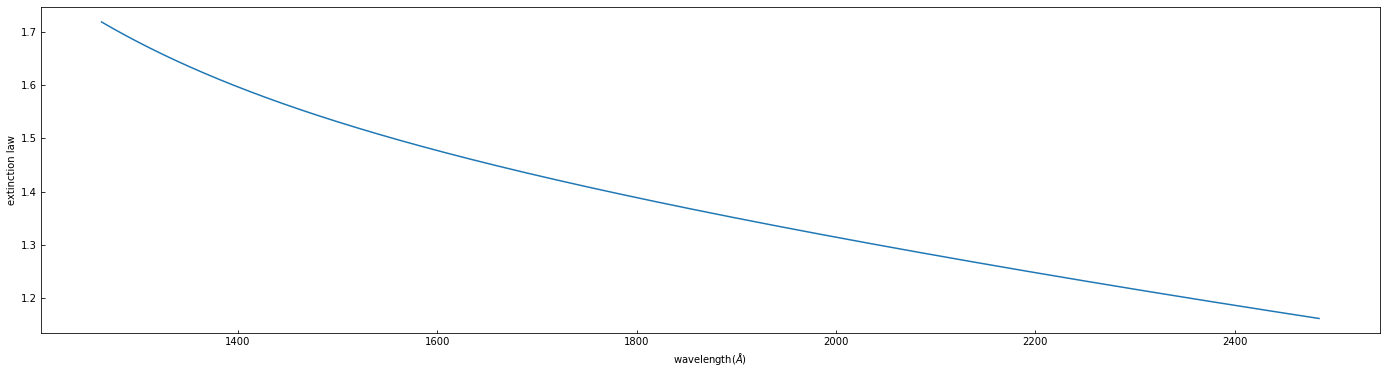

In [251]:
fig,ax1 = plt.subplots(figsize=(24,6))
plt.rcParams['xtick.direction'] = 'in'#将x周的刻度线方向设置向内
plt.rcParams['ytick.direction'] = 'in'#将y轴的刻度方向设置向内
ax1.plot(WL,ext_line)
ax1.set_xlabel('wavelength($\AA$)')
ax1.set_ylabel('extinction law')

In [252]:
extinction_factor = [10**(0.4*i) for i in ext_line]
ext_df = pd.DataFrame({'wavelength':WL, 'ext_factor': extinction_factor})
ext_df.set_index('wavelength', inplace=True)
ext_df

,ext_factor
wavelength,
1263.36,4.866392
1263.78,4.864340
1264.20,4.862292
1264.62,4.860247
1265.04,4.858206
...,...
2481.24,2.919234
2482.07,2.918593
2482.89,2.917960


In [253]:
#test1.loc[:, 'total'] = test1.loc[:, 'total']/ext_df.loc[:, 'ext_factor']
#mean_value = test1[(test1.index >= 1495) & (test1.index <= 1505)].loc[:,'total'].mean()
#test1.loc[:,'total'] = test1.loc[:,'total']/mean_value

#test1.loc[:, 'total']

In [254]:
continuum = []
fitting_data = []
for i in category.index.tolist():
    simulation_result = pd.read_csv(location + str(i) + '/model.cont', sep='\\s+')
    simulation_result.drop(labels=['cont', 'nLine'],axis=1, inplace=True)
    simulation_result.sort_values(by=['#Cont'], ascending=True, inplace=True)
    simulation_result.columns = ['wavelength', 'incident', 'trans', 'DiffOut', 'net_trans', 'reflec', 'total', 'sum_reflec', 'sum_outline', 'line_label', 'continuum_label', 'N_lines']
    S3_simulation = simulation_result[(simulation_result.loc[:, 'wavelength'] >= 1263) & (simulation_result.loc[:, 'wavelength'] <= 2485)]
    test = pd.concat([S3_simulation.loc[:,'wavelength'], S3_simulation.loc[:,'total']], axis=1)
    test.set_index('wavelength', inplace=True)
    test.loc[:, 'total'] = test.loc[:, 'total']/ext_df.loc[:, 'ext_factor']
    mean_value = test[(test1.index >= 1495) & (test.index <= 1505)].loc[:,'total'].mean()
    test.loc[:,'total'] = test.loc[:,'total']/mean_value

    continuum.append(test)
    fitting_data.append(test.copy())

In [255]:
wl_thre = [5520, 5540, 5590, 5630, 5900, 5930, 6090, 6110, 6120, 6140, 6170, 6190, 6420, 6480, 6580, 6620, 6720, 6730, 6940, 7000, 7090, 7100]
wl_thre = [round(r_rs_convert(i, redshift_given),4) for i in wl_thre]

drop1 = list(fitting_data[0].index[(fitting_data[0].index >wl_thre[0]) & (fitting_data[0].index <wl_thre[1])])
drop2 = list(fitting_data[0].index[(fitting_data[0].index >wl_thre[2]) & (fitting_data[0].index <wl_thre[3])])
drop3 = list(fitting_data[0].index[(fitting_data[0].index >wl_thre[4]) & (fitting_data[0].index <wl_thre[5])])
drop4 = list(fitting_data[0].index[(fitting_data[0].index >wl_thre[6]) & (fitting_data[0].index <wl_thre[7])])
drop5 = list(fitting_data[0].index[(fitting_data[0].index >wl_thre[8]) & (fitting_data[0].index <wl_thre[9])])
drop6 = list(fitting_data[0].index[(fitting_data[0].index >wl_thre[10]) & (fitting_data[0].index <wl_thre[11])])
drop7 = list(fitting_data[0].index[(fitting_data[0].index >wl_thre[12]) & (fitting_data[0].index <wl_thre[13])])
drop8 = list(fitting_data[0].index[(fitting_data[0].index >wl_thre[14]) & (fitting_data[0].index <wl_thre[15])])
drop9 = list(fitting_data[0].index[(fitting_data[0].index >wl_thre[16]) & (fitting_data[0].index <wl_thre[17])])
drop10 = list(fitting_data[0].index[(fitting_data[0].index >wl_thre[18]) & (fitting_data[0].index <wl_thre[19])])
drop11 = list(fitting_data[0].index[(fitting_data[0].index >wl_thre[20]) & (fitting_data[0].index <wl_thre[21])])

for i in range(len(fitting_data)):
    fitting_data[i].drop(index = drop1, inplace = True)
    fitting_data[i].drop(index = drop2, inplace = True)
    fitting_data[i].drop(index = drop3, inplace = True)
    fitting_data[i].drop(index = drop4, inplace = True)
    fitting_data[i].drop(index = drop5, inplace = True)
    fitting_data[i].drop(index = drop6, inplace = True)
    fitting_data[i].drop(index = drop7, inplace = True)
    fitting_data[i].drop(index = drop8, inplace = True)
    fitting_data[i].drop(index = drop9, inplace = True)
    fitting_data[i].drop(index = drop10, inplace = True)
    fitting_data[i].drop(index = drop11, inplace = True)

S3_fitting = S3_df.copy()

S3_fitting.drop(index = drop1, inplace = True)
S3_fitting.drop(index = drop2, inplace = True)
S3_fitting.drop(index = drop3, inplace = True)
S3_fitting.drop(index = drop4, inplace = True)
S3_fitting.drop(index = drop5, inplace = True)
S3_fitting.drop(index = drop6, inplace = True)
S3_fitting.drop(index = drop7, inplace = True)
S3_fitting.drop(index = drop8, inplace = True)
S3_fitting.drop(index = drop9, inplace = True)
S3_fitting.drop(index = drop10, inplace = True)
S3_fitting.drop(index = drop11, inplace = True)


# Chi square fit

In [256]:
def read_chi_square(data, error, simulation_data):
    chi_square = sum((data - simulation_data)**2/(error**2))
    reduced_chi_square = chi_square/(len(data) - 1)
    return reduced_chi_square

In [257]:
chi_square_list = []

wl_low = 1300
wl_high = 2400

fit_data = S3_fitting.loc[wl_low:wl_high, 'MUSE_data']
fit_error = S3_fitting.loc[wl_low:wl_high, 'MUSE_err']

#fit_data = S3_df.loc[:, 'MUSE_data']
#fit_error = S3_df.loc[:, 'MUSE_err']

for i in range(len(continuum)):
    value = read_chi_square(fit_data, fit_error, fitting_data[i].loc[wl_low:wl_high, 'total'])
    #value = read_chi_square(fit_data, fit_error, continuum[i].loc[:,'total'])
    chi_square_list.append(value)

In [258]:
best_fit_model = chi_square_list.index(min(chi_square_list))
min(chi_square_list)

3.536571102715996

(0.0, 3.0)

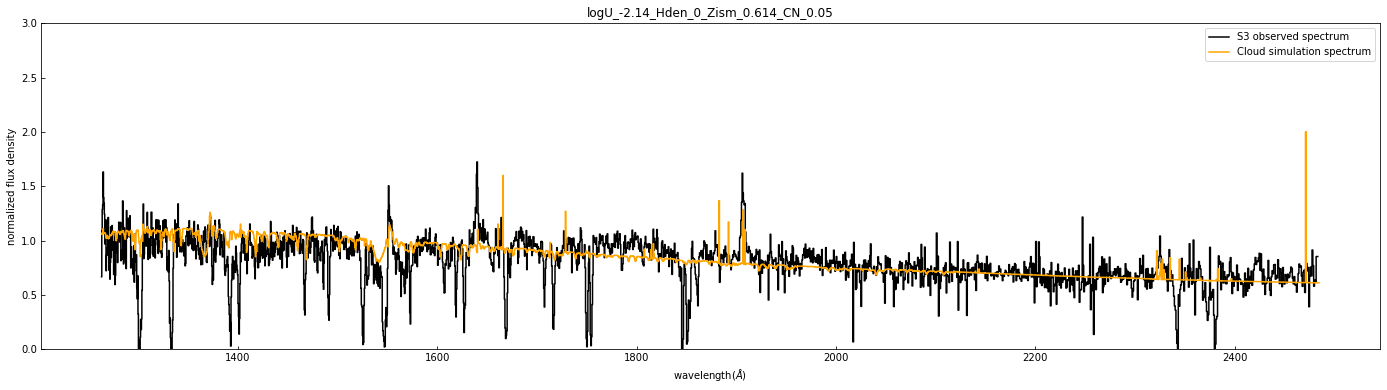

In [259]:
fig,ax1 = plt.subplots(figsize=(24,6))
plt.rcParams['xtick.direction'] = 'in'#将x周的刻度线方向设置向内
plt.rcParams['ytick.direction'] = 'in'#将y轴的刻度方向设置向内
ax1.step(WL, S3_df.loc[:, 'MUSE_data'], 'black', where='mid', label = 'S3 observed spectrum')
ax1.step(WL, continuum[best_fit_model].loc[:, 'total'], 'orange', where='mid', label = 'Cloud simulation spectrum')
ax1.set_xlabel('wavelength($\AA$)')
ax1.set_ylabel('normalized flux density')
ax1.legend()
ax1.set_title(category.loc[chi_square_list.index(min(chi_square_list)), 'name'])
ax1.set_ylim(0,3)

In [260]:
Halpha = 'H  1                6562.81A'
Hbeta = 'H  1                4861.33A'
Heii1640 = 'He 2                1640.43A'
Ciii1906 = 'C  3                1906.68A'
Ciii1908 = 'C  3                1908.73A'
Civ1548 = 'C  4                1548.19A'
Civ1550 = 'C  4                1550.78A'

Halpha_list = []
Hbeta_list = []
Heii1640_list = []
Ciii1906_list = []
Ciii1908_list = []
Civ1548_list = []
Civ1550_list = []

for i in category.index.tolist():
    line_info = pd.read_csv(location + str(i) + '/model_lines.arr', sep='\t')
    line_info.columns = ['energy', 'label', 'I(intrinsic)', 'I(emergent)', 'type']
    a = float(line_info[line_info.loc[:,'label'] == Halpha].loc[:,'I(emergent)'])
    b = float(line_info[line_info.loc[:,'label'] == Hbeta].loc[:,'I(emergent)'])
    c = float(line_info[line_info.loc[:,'label'] == Heii1640].loc[:,'I(emergent)'])
    d = float(line_info[line_info.loc[:,'label'] == Ciii1906].loc[:,'I(emergent)'])
    e = float(line_info[line_info.loc[:,'label'] == Ciii1908].loc[:,'I(emergent)'])
    f = float(line_info[line_info.loc[:,'label'] == Civ1548].loc[:,'I(emergent)'])
    g = float(line_info[line_info.loc[:,'label'] == Civ1550].loc[:,'I(emergent)'])
    Halpha_list.append(a)
    Hbeta_list.append(b)
    Heii1640_list.append(c)
    Ciii1906_list.append(d)
    Ciii1908_list.append(e)
    Civ1548_list.append(f)
    Civ1550_list.append(g)

emission_line_info = pd.DataFrame({'index': category.index.tolist(), 'name':category.loc[:,'name'].tolist(), 'Halpha': Halpha_list, 'Heii1640':Heii1640_list, 'Ciii1906': Ciii1906_list, 'Ciii1908':Ciii1908_list, 'Civ1548':Civ1548_list, 'Civ1550':Civ1550_list, 'Hbeta':Hbeta_list})

emission_line_info.set_index('index',inplace = True)
emission_line_info.iloc[:,1:] = 10**emission_line_info.iloc[:,1:]

In [261]:
Heii_ext = ext_df[(ext_df.index > 1639) & (ext_df.index < 1641)].mean()

Ciii1906_ext = ext_df[(ext_df.index > 1905) & (ext_df.index < 1907)].mean()

Ciii1908_ext = ext_df[(ext_df.index > 1907) & (ext_df.index < 1909)].mean()

Civ1548_ext = ext_df[(ext_df.index > 1547) & (ext_df.index < 1549)].mean()

Civ1550_ext = ext_df[(ext_df.index > 1549) & (ext_df.index < 1551)].mean()

#Heii = emission_line_info.loc[best_fit_model, 'Heii1640']/10**(0.4*Heii_ext)
#Ciii = emission_line_info.loc[best_fit_model, 'Ciii1906']/10**(0.4*Ciii1906_ext) + emission_line_info.loc[best_fit_model, 'Ciii1908']/10**(0.4*Ciii1908_ext)
#Civ = emission_line_info.loc[best_fit_model, 'Civ1548']/10**(0.4*Civ1548_ext) + emission_line_info.loc[best_fit_model, 'Civ1550']/10**(0.4*Civ1548_ext)

In [262]:
#Ciii_Heii = Ciii/Heii
#Civ_Heii = Civ/Heii
#Civ_Ciii = Civ/Heii

In [263]:

Heii = emission_line_info.loc[:, 'Heii1640']/10**(0.4*Heii_ext)
Ciii = emission_line_info.loc[:, 'Ciii1906']/10**(0.4*Ciii1906_ext) + emission_line_info.loc[:, 'Ciii1908']/10**(0.4*Ciii1908_ext)
Civ = emission_line_info.loc[:, 'Civ1548']/10**(0.4*Civ1548_ext) + emission_line_info.loc[:, 'Civ1550']/10**(0.4*Civ1548_ext)

In [264]:
HeII = emission_line_info.loc[:, 'Heii1640']/10**(0.4*float(Heii_ext))
CIII = emission_line_info.loc[:, 'Ciii1906']/10**(0.4*float(Ciii1906_ext)) + emission_line_info.loc[:, 'Ciii1908']/10**(0.4*float(Ciii1908_ext))
CIV = emission_line_info.loc[:, 'Civ1548']/10**(0.4*float(Civ1548_ext)) + emission_line_info.loc[:, 'Civ1550']/10**(0.4*float(Civ1548_ext))

In [265]:
line_ratio_df = pd.concat([emission_line_info.loc[:, 'name'], CIV/HeII, CIII/HeII, CIV/CIII],axis = 1)
line_ratio_df.columns = ['name', 'Civ/Heii', 'Ciii/Heii', 'Civ/Ciii']


fitting_df = pd.DataFrame(columns=['name', 'Civ/Heii', 'Ciii/Heii', 'Civ/Ciii'])

fitting_df.loc[:,'name'] = line_ratio_df.loc[:,'name']

fitting_df.loc[:,'Civ/Heii'] = line_ratio_df.loc[:,'Civ/Heii']
fitting_df.loc[:,'Ciii/Heii'] = line_ratio_df.loc[:,'Ciii/Heii']
fitting_df.loc[:,'Civ/Ciii'] = line_ratio_df.loc[:,'Civ/Ciii']


0.8239126589414747
name         logU_-2.14_Hden_2_Zism_1.382_CN_0.05
Civ/Heii                                 0.993272
Ciii/Heii                                 2.02541
Civ/Ciii                                 0.490404
Name: 175, dtype: object
S3:CIV/HeII 1.7403786616538477
S3:CIII/HeII 2.095003199396641
S3:CIV/CIII 0.8307284027800411


(0.0, 3.0)

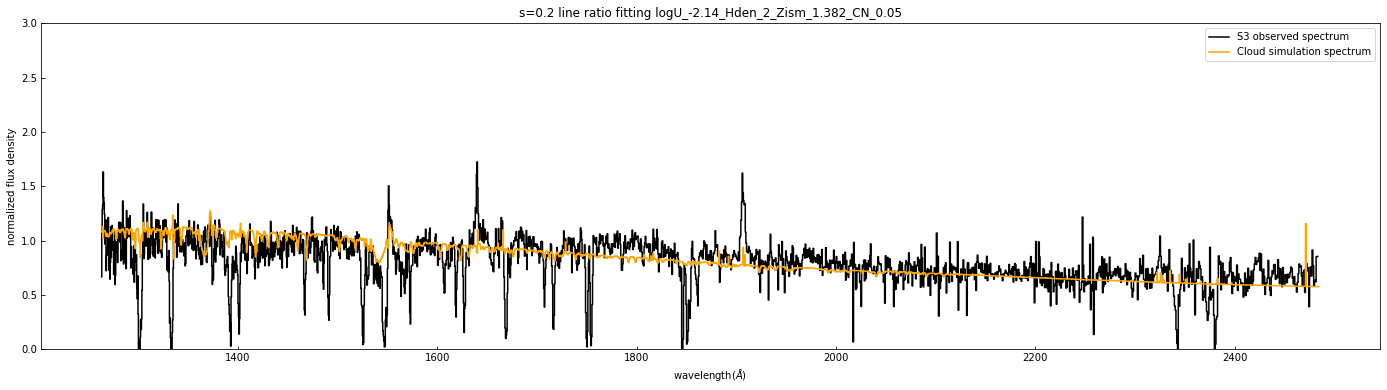

In [266]:
S3_HeII = 1933.177
S3_CIII = 4050.012
S3_CIV = 3364.46

S3_CIII_HeII = S3_CIII/S3_HeII
S3_CIV_HeII = S3_CIV/S3_HeII
S3_CIV_CIII = S3_CIV/S3_CIII


fitting_df.loc[:,'Civ/Heii'] = abs(fitting_df.loc[:,'Civ/Heii'] - S3_CIV_HeII)
fitting_df.loc[:,'Ciii/Heii'] = abs(fitting_df.loc[:,'Ciii/Heii'] - S3_CIII_HeII)
fitting_df.loc[:,'Civ/Ciii'] = abs(fitting_df.loc[:,'Civ/Ciii'] - S3_CIV_CIII)

phase_distant = np.sqrt(fitting_df.loc[:,'Civ/Heii']**2 + fitting_df.loc[:,'Ciii/Heii']**2 + fitting_df.loc[:,'Civ/Ciii']**2).tolist()
best_fit_model_line_ratio = phase_distant.index(min(phase_distant))

print(phase_distant[best_fit_model_line_ratio])

print(line_ratio_df.iloc[best_fit_model_line_ratio,:4])

print('S3:CIV/HeII'+ ' ' + str(S3_CIV_HeII))
print('S3:CIII/HeII'+ ' ' + str(S3_CIII_HeII))
print('S3:CIV/CIII'+ ' ' + str(S3_CIV_CIII))




fig,ax1 = plt.subplots(figsize=(24,6))
plt.rcParams['xtick.direction'] = 'in'#将x周的刻度线方向设置向内
plt.rcParams['ytick.direction'] = 'in'#将y轴的刻度方向设置向内
ax1.step(WL, S3_df.loc[:, 'MUSE_data'], 'black', where='mid', label = 'S3 observed spectrum')
ax1.step(WL, continuum[best_fit_model_line_ratio].loc[:, 'total'], 'orange', where='mid', label = 'Cloud simulation spectrum')
ax1.set_xlabel('wavelength($\AA$)')
ax1.set_ylabel('normalized flux density')
ax1.legend()
ax1.set_title('s=0.2' + ' ' + 'line ratio fitting' + ' ' + category.loc[best_fit_model_line_ratio, 'name'])
ax1.set_ylim(0,3)